# Cancer Detection with Modern Image Models

Many notebooks on Kaggle use dated models like ResNet and dated packages like pretrained.

In this notebook we use modern packages like timm and modern models from this library.

In [1]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.style as style
import torch
import glob
import json
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from torch.utils.data import Subset, Dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, DefaultDataCollator, EarlyStoppingCallback

os.environ["WANDB_DISABLED"] = "true"

/home/adaly/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = './data'
model_name = "timm/" + "convnextv2_pico.fcmae_ft_in1k"
# model_name = "microsoft/resnet-34"
# "microsoft/resnet-34"
# "repvit_m2.dist_in1k"

simple_model_name = 'convnextv2'

finetune = False

if finetune:
    simple_model_name = simple_model_name + '-fine'
else:
    simple_model_name = simple_model_name + '-full'

# check if directory exists, if not create it
if not os.path.exists(f'results/{simple_model_name}/'):
    os.mkdir(f'results/{simple_model_name}')

# 1. Data Loading

In [4]:
labels = pd.read_csv(f'{data_dir}/train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print(f'{len(os.listdir("./data/train"))} pictures in train.')
print(f'{len(os.listdir("./data/test"))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


# 2. Class Distribution

Text(0.5, 1.0, 'Class Distribution')

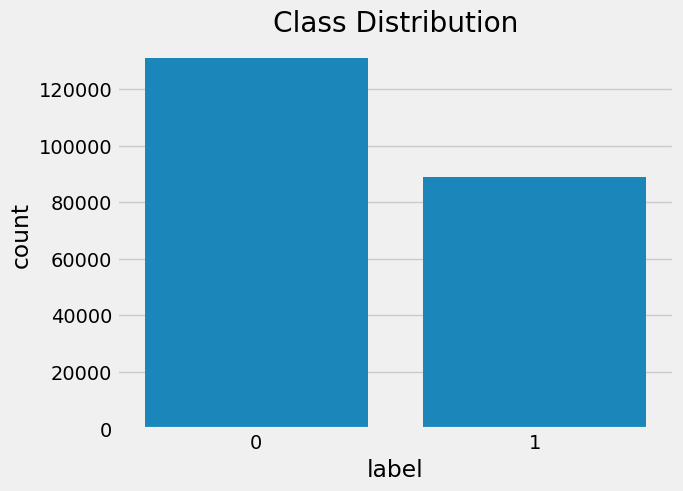

In [6]:
sns.countplot(x='label',data=labels).set_title("Class Distribution")

# 3. Exploratory Data Analysis

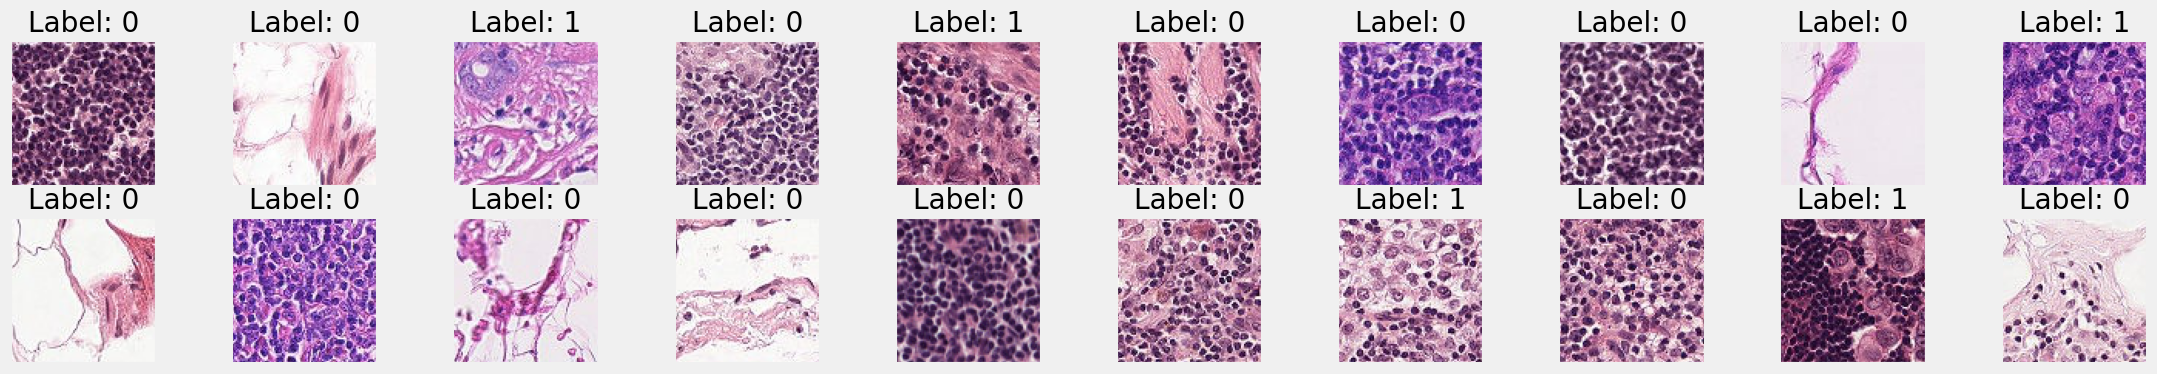

In [7]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir(f"{data_dir}/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(f"{data_dir}/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

# 4. Image Normalization & Dataset Preparation

In [8]:
# dictionary with labels and ids of train data
img_class_dict = {k:v for k, v in zip(labels.id, labels.label)}

In [9]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, datatype='train', processor=None, labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.processor = processor
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name).convert("RGB")
        
        processed_image = self.processor(images=image, return_tensors="pt")
        
        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
            
        return {"pixel_values": processed_image['pixel_values'].squeeze(0), "labels": torch.tensor(label)}

# 5. Data Loaders

Optimization ideas implemented:

Increased num_workers.

Increased batch size to work with larger memory

Set pin_memory=True

Added an early stopping callback to stop if more than 2 epochs have no improvement in validation loss.

In [10]:
# Load model directly
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=2, torch_dtype="auto", ignore_mismatched_sizes=True)  
data_collator = DefaultDataCollator()

dataset = CancerDataset(datafolder=f'{data_dir}/train/', datatype='train', processor=processor, labels_dict=img_class_dict)
test_set = CancerDataset(datafolder=f'{data_dir}/test/', datatype='test', processor=processor)

if finetune:
    for param in model.timm_model.parameters():
        param.requires_grad = False

    # Unfreeze the classifier head
    for param in model.timm_model.get_classifier().parameters():
        param.requires_grad = True

    # Verify which layers are trainable
    print("Trainable parameters:")
    for name, param in model.timm_model.named_parameters():
        if param.requires_grad:
            print(name)

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at timm/convnextv2_pico.fcmae_ft_in1k and are newly initialized because the shapes did not match:
- timm_model.head.fc.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- timm_model.head.fc.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tr, val = train_test_split(labels.label, stratify=labels.label, test_size=0.1)
train_dataset = Subset(dataset, list(tr.index))
valid_dataset = Subset(dataset, list(val.index))

In [12]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "roc_auc": roc_auc_score(p.label_ids, p.predictions[:, 1])
    }

In [13]:
early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Stop after 3 evaluations without improvement
        early_stopping_threshold=0.001 # Minimum improvement needed to reset patience
    )

TODO: Experiment with optimizer and scheduler in below training arguments.

In [ ]:
training_args = TrainingArguments(
    output_dir=f"./runs/{simple_model_name}",
    per_device_train_batch_size=128,
    eval_strategy="epoch",
    num_train_epochs=20,
    fp16=True,
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-3,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    dataloader_num_workers=6,
    dataloader_pin_memory=True,
    load_best_model_at_end=True,
    max_grad_norm=1.0,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    processing_class=processor,
    callbacks=[early_stopping_callback]
)

trainer.train()

Epoch,Training Loss,Validation Loss


# 6. Submission Generation

In [ ]:
model.eval()
predictions = trainer.predict(test_set)
preds = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=1)[:, 1].tolist()



/home/adaly/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
test_preds = pd.DataFrame({'imgs': test_set.image_files_list, 'preds': preds})
test_preds['id'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])

In [ ]:
sub = pd.read_csv(f'{data_dir}/sample_submission.csv')
sub = pd.merge(sub, test_preds, left_on='id', right_on='id')

In [ ]:
sub = sub[['id', 'preds']]
sub.columns = ['id', 'label']
sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.009477
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.069922
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001934
3,2c35657e312966e9294eac6841726ff3a748febf,0.025933
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.010818


In [ ]:
sub.to_csv(f'results/{simple_model_name}/{simple_model_name}-submission.csv', index=False)

In [ ]:
trainer.state.log_history

[{'loss': 0.2516,
  'grad_norm': 0.6016313433647156,
  'learning_rate': 0.0019001291989664082,
  'epoch': 1.0,
  'step': 1548},
 {'eval_loss': 0.19298584759235382,
  'eval_accuracy': 0.9291914738899241,
  'eval_roc_auc': 0.9739652219715849,
  'eval_runtime': 20.776,
  'eval_samples_per_second': 1059.057,
  'eval_steps_per_second': 132.412,
  'epoch': 1.0,
  'step': 1548},
 {'loss': 0.1683,
  'grad_norm': 2.782970666885376,
  'learning_rate': 0.0018001291989664084,
  'epoch': 2.0,
  'step': 3096},
 {'eval_loss': 0.1520654261112213,
  'eval_accuracy': 0.9448711539335545,
  'eval_roc_auc': 0.9826745198748104,
  'eval_runtime': 20.7264,
  'eval_samples_per_second': 1061.594,
  'eval_steps_per_second': 132.729,
  'epoch': 2.0,
  'step': 3096},
 {'loss': 0.1432,
  'grad_norm': 4.745525360107422,
  'learning_rate': 0.0017001291989664083,
  'epoch': 3.0,
  'step': 4644},
 {'eval_loss': 0.14058852195739746,
  'eval_accuracy': 0.9480525382902332,
  'eval_roc_auc': 0.9856907513109657,
  'eval_run

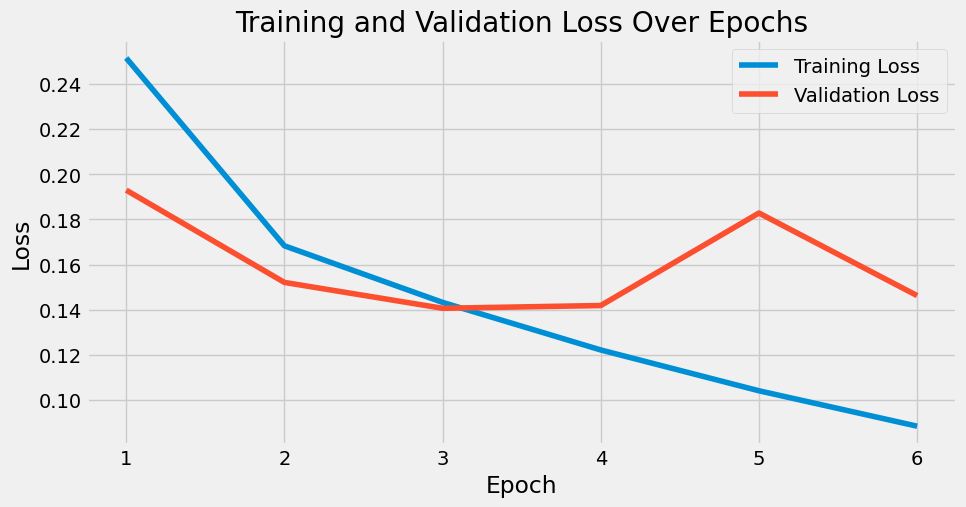

In [ ]:

# Extracting loss values from the log history

epochs = [entry['epoch'] for entry in trainer.state.log_history if 'loss' in entry]
n_epochs = len(epochs)
train_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry][:n_epochs]
eval_loss = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry][:n_epochs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'results/{simple_model_name}/{simple_model_name}-loss-plot.png')
plt.show()


In [ ]:
# Final evaluation
final_metrics = trainer.evaluate()

# Preparing data for JSON
results_to_save = {
    "model_name": simple_model_name,
    "final_metrics": final_metrics,
    "log_history": trainer.state.log_history,
}

# Writing to a JSON file
results_filename = f'results/{simple_model_name}/{simple_model_name}-results.json'
with open(results_filename, 'w') as f:
    json.dump(results_to_save, f, indent=4)

print(f"Final metrics and training history saved to {results_filename}")
print("Final evaluation metrics:", final_metrics)

Final metrics and training history saved to results/resnet34-full/resnet34-full-results.json
Final evaluation metrics: {'eval_loss': 0.14058852195739746, 'eval_accuracy': 0.9480525382902332, 'eval_roc_auc': 0.9856907513109657, 'eval_runtime': 20.7983, 'eval_samples_per_second': 1057.924, 'eval_steps_per_second': 132.271, 'epoch': 6.0}


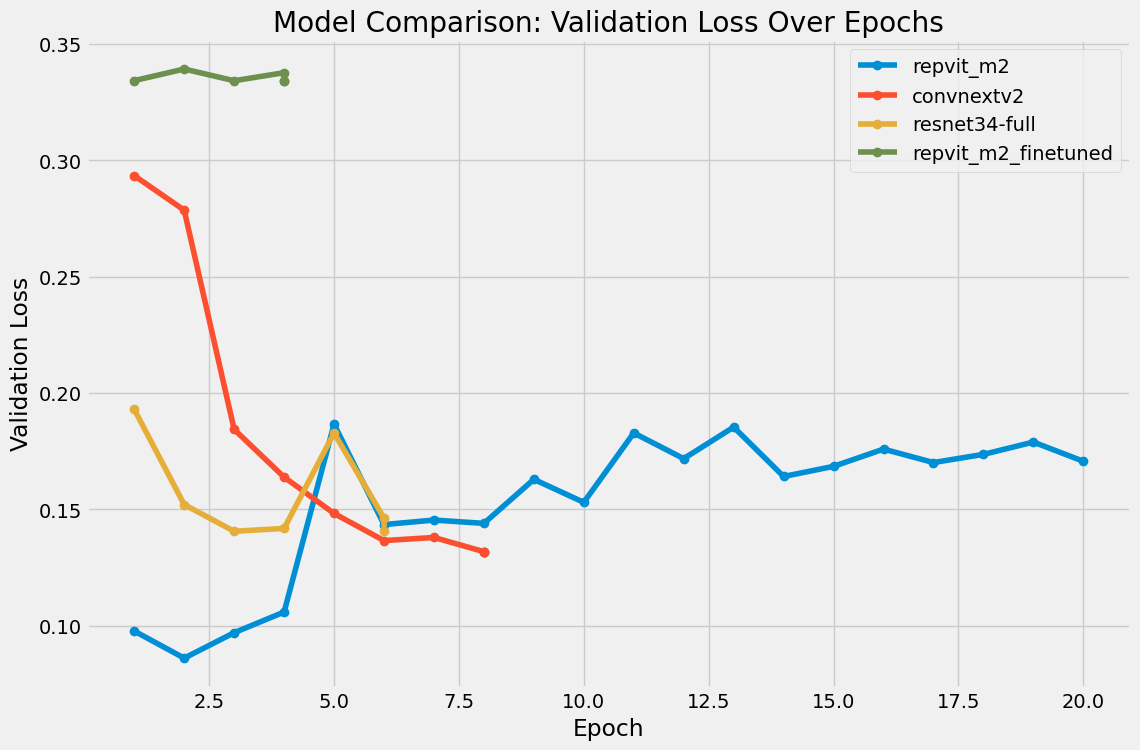

In [ ]:

# Comparing multiple models from results directory
plt.figure(figsize=(12, 8))

for result_file in glob.glob('results/*/*-results.json'):
    with open(result_file, 'r') as f:
        data = json.load(f)
    
    model_name = data.get('model_name', 'Unknown Model')
    log_history = data.get('log_history', [])
    
    eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
    epochs = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]
    
    if epochs and eval_loss:
        plt.plot(epochs, eval_loss, marker='o', linestyle='-', label=model_name)

plt.title('Model Comparison: Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# 7. References

https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055-2/
https://github.com/huggingface/pytorch-image-models/blob/main/results/README.md
